Practical Test:
Please find data set attached.

Info about data:
A customer has a specific acquisition date for when his first subscription started

Every month, a new subscription is generated if the customer did not cancel

Subscriptions are always from day X in month 1 to day (X-1) in following month

Tasks for Practical Test:

What can you say about the data set?

Analyze the data provided. Compile KPI reports such as Cohort Retention, Profit Contribution etc.

Interpret your results and draw conclusions for the business.

Which additional data points would you like to look at for better analysis and conclusions? Prioritize them.

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import numpy as np

sns.set(style='white')

%matplotlib inline

In [2]:
data = pd.read_excel('/Users/joaosantos/Downloads/USC BI Test case - Data Set.xlsx')

In [9]:
data.head()

,Customer ID,country,Product type,full product price,Acquisition_date,Marketing Channel,Subscription Date,Revenue,Cost
0,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-01-02,34.3,37.86
1,3.0,Country 1,product_4,39,2015-01-13,Channel 1,2015-01-13,39.0,8.00
2,4.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,7.50
3,5.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,29.06
4,6.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,15.00


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29619 entries, 0 to 29618
Data columns (total 9 columns):
Customer id           29213 non-null float64
Country               29619 non-null object
Product type          29619 non-null object
Full product price    29619 non-null int64
Acquisition_date      28191 non-null datetime64[ns]
Marketing channel     29619 non-null object
Subscription date     28191 non-null datetime64[ns]
Revenue               29619 non-null float64
Cost                  29619 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(1), object(3)
memory usage: 2.0+ MB


In [10]:
#Make columns names uniform
data.columns = data.columns.str.capitalize()

In [52]:
#Remove duplicates
data.drop_duplicates(inplace=True)

In [509]:
data.loc[data['Country']=='Country 1',:].head()

,Customer id,Country,Product type,Full product price,Acquisition_date,Marketing channel,Subscription date,Revenue,Cost
0,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-01-02,34.3,37.86
1,3.0,Country 1,product_4,39,2015-01-13,Channel 1,2015-01-13,39.0,8.00
2,4.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,7.50
3,5.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,29.06
4,6.0,Country 1,product_4,39,2015-01-21,Channel 1,2015-01-21,31.2,15.00


## Contribution Margin

Price per unit - Cost per product = Contribution margin per unit aka profit per unit

In [410]:
contribution_margin = data.copy(deep=False)

In [411]:
contribution_margin_sum = contribution_margin.groupby('Product type')[['Revenue','Cost']].sum()
contribution_margin_count = contribution_margin.groupby('Product type')[['Revenue']].count()
contribution_margin = contribution_margin_sum.merge(contribution_margin_count,how='inner', left_index=True, right_index=True)


In [412]:
contribution_margin['revenue_per_unit'] = contribution_margin['Revenue_x']/contribution_margin['Revenue_y']
contribution_margin['cost_per_unit'] = contribution_margin['Cost']/contribution_margin['Revenue_y']
contribution_margin['margin_per_unit'] = contribution_margin['revenue_per_unit']-contribution_margin['cost_per_unit']
contribution_margin.rename(columns={'Revenue_x': 'total_revenue',
                                   'Revenue_y': 'total_units',
                                   'Cost': 'total_cost'}, inplace=True)

In [413]:
contribution_margin


,total_revenue,total_cost,total_units,revenue_per_unit,cost_per_unit,margin_per_unit
Product type,,,,,,
product_1,859206.98,869640.92,14444,59.485390,60.207762,-0.722372
product_3,160250.67,162124.10,2184,73.374849,74.232647,-0.857798
product_4,329509.78,333229.27,12986,25.374232,25.660655,-0.286423


## Cohort Retention Analysis

In [95]:
cohort_df = data.copy(deep=False) 
cohort_df.dropna(inplace=True)
cohort_df['Cohort_customer'] = cohort_df['Acquisition_date'].apply(lambda x: x.strftime('%Y-%m'))
cohort_df['Cohort_subscription'] = cohort_df['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))

In [96]:
cohort_df.sort_values('Customer id').head()#.groupby('Cohort_period').count()

,Customer id,Country,Product type,Full product price,Acquisition_date,Marketing channel,Subscription date,Revenue,Cost,Cohort_customer,Cohort_subscription
0,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-01-02,34.30,37.86,2015-01,2015-01
6593,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-04-02,1.23,1.01,2015-01,2015-04
6594,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-05-02,18.76,20.48,2015-01,2015-05
6595,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-06-02,35.30,23.97,2015-01,2015-06
6596,2.0,Country 1,product_4,39,2015-01-02,Channel 1,2015-07-02,26.54,22.85,2015-01,2015-07


In [97]:
cohorts_group = cohort_df.groupby(['Cohort_customer','Cohort_subscription'])

In [98]:
cohorts = cohorts_group.agg({'Customer id': pd.Series.nunique,
                            'Cost': np.sum,
                            'Revenue': np.sum}
                           ).rename(columns={'Customer id': 'Total_Customers',
                                            'Cost': 'Total_Cost',
                                            'Revenue': 'Total_Revenue'})

In [99]:
cohorts['contribution_margin'] = cohorts['Total_Revenue'] - cohorts['Total_Cost']

In [101]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [81]:
cohorts.head()

Total_Subscriptions  Total_Cost  Total_Revenue  contribution_margin  CohortPeriod
Cohort_customer Cohort_subscription                                                                                   
2015-01         2015-01                              141     4745.92        6008.53              1262.61             1
                2015-02                              111     3788.23        4889.99              1101.76             2
                2015-03                              171     6758.37        7440.63               682.26             3
                2015-04                              117     4753.05        5022.11               269.06             4
                2015-05                              165     6434.42        7206.60               772.18             5

In [102]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['Cohort_customer', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['Total_Customers'].groupby(level=0).first()


In [103]:
cohort_group_size.head()

Cohort_customer
2015-01    141.0
2015-02     80.0
2015-03    147.0
2015-04     61.0
2015-05     93.0
Name: Total_Customers, dtype: float64

In [104]:
user_retention = cohorts['Total_Customers'].unstack(0).divide(cohort_group_size, axis=1)


In [105]:
user_retention.fillna(0,inplace=True)

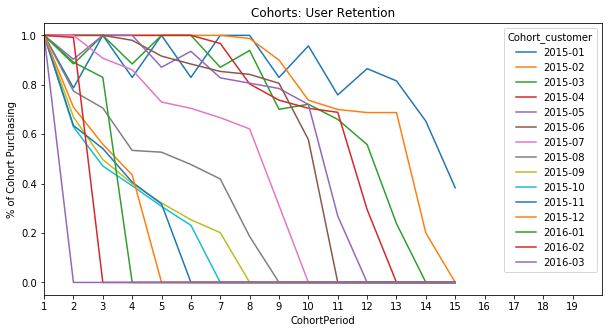

In [106]:
user_retention.plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 20, 1))
plt.xlim(1, 20)
plt.ylabel('% of Cohort Purchasing');

### Churn Rate

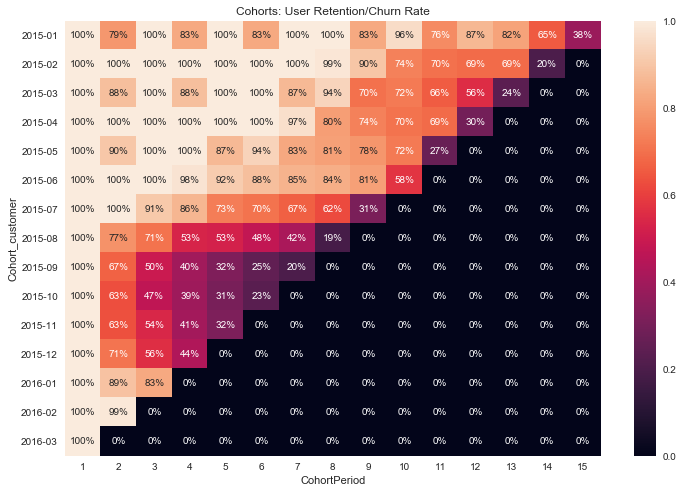

In [112]:
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention/Churn Rate')
sns.heatmap(user_retention.T, annot=True, fmt='.0%');

From this heatmap you can clearly see that the most recent cohorts have a much more accelerated churn rate than the beginning of 2015 Cohorts that have a much smoother churn rate, especially the last 6 months of 2015.

## Sales Growth

[(Sales for the current period - Sales for the previous period) / Sales for the previous period] x 100

In [118]:
sales_growth = data.copy(deep=False)
sales_growth.dropna(inplace=True)
sales_growth['Month'] = sales_growth['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))

Month
2015-01     141
2015-02     191
2015-03     368
2015-04     388
2015-05     522
2015-06     972
2015-07    1574
2015-08    2257
2015-09    2770
2015-10    3006
2015-11    2819
2015-12    2811
2016-01    3176
2016-02    3473
2016-03    3359
Name: Customer id, dtype: int64

In [141]:
sales_current_period = sales_growth.groupby('Month')['Customer id'].nunique().rename(columns={'Customer id': 'sales_current_period'})
sales_previous_period = sales_growth.groupby('Month')['Customer id'].nunique().shift(1)

In [142]:
sales_growth_df = pd.concat([sales_current_period,sales_previous_period], axis=1).rename(columns={0: 'sales_current_period','Customer id': 'sales_last_period'})

In [144]:
sales_growth_df['sales_growth'] = (sales_growth_df['sales_current_period'] - sales_growth_df['sales_last_period'])/sales_growth_df['sales_last_period']*100

In [145]:
sales_growth_df

,sales_current_period,sales_last_period,sales_growth
Month,,,
2015-01,141,NaN,NaN
2015-02,191,141.0,35.460993
2015-03,368,191.0,92.670157
2015-04,388,368.0,5.434783
2015-05,522,388.0,34.536082
2015-06,972,522.0,86.206897
2015-07,1574,972.0,61.934156
2015-08,2257,1574.0,43.392630
2015-09,2770,2257.0,22.729287


#check if the sum revenue stagnated at some point and we stop providing revenue at higher rates

## Product Performance
Rank products based on revenue performance.

In [153]:
#Pie chart with Revenue, Subscriptions sold

In [155]:
product_performance = data.copy(deep=False)

In [158]:
product_performance = product_performance.groupby('Product type')[['Revenue','Cost']].sum()

In [161]:
product_performance.reset_index(inplace=True)

Text(-0.14,-0.06,'Cost %')

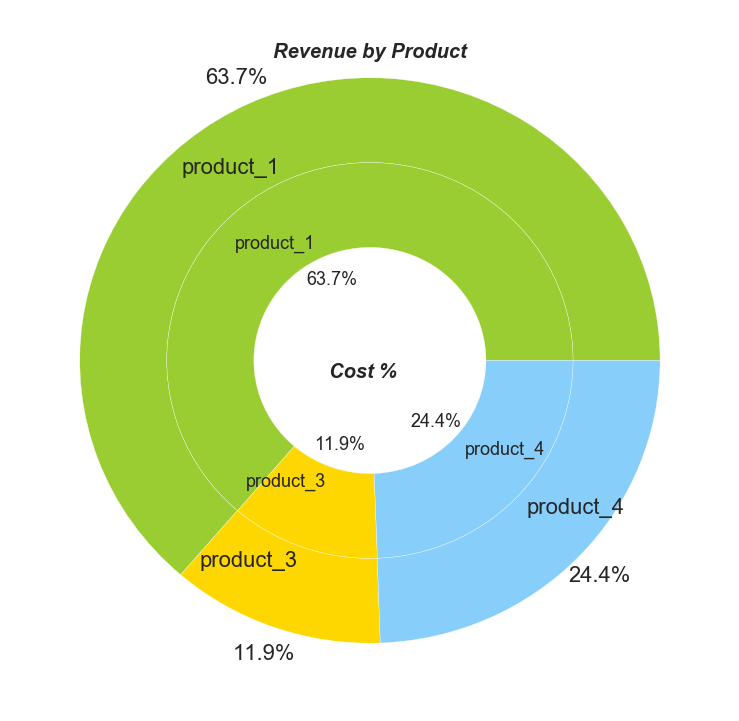

In [174]:
#plot nested pie chart with clicks per user by channel
fig, ax = plt.subplots(figsize=(13,13))
labels1 = list(product_performance['Product type'])
labels2 = list(product_performance['Product type'])
size = 0.3
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']

ax.pie(product_performance['Revenue'], radius=1,textprops={'fontsize': 22}, 
       shadow=False, labels=labels1, labeldistance=0.75, colors=colors, wedgeprops=dict(width=size, edgecolor='w'),
#        autopct=lambda x: '{:.2f}'.format(x * channel_ROI['ROI'].sum() / 100), 
       autopct='%.1f%%',pctdistance=1.1)
ax.pie(product_performance['Cost'], radius=1-size, textprops={'fontsize': 18}, labels=labels2, 
       shadow=False, rotatelabels=0, labeldistance=0.65, colors=colors, wedgeprops=dict(width=size, edgecolor='w'), 
       autopct='%.1f%%', pctdistance=0.45)
ax.set_title('''Revenue by Product''', fontsize=20, fontstyle='oblique', fontweight='bold', position=(0.5,0.92))
ax.annotate('''Cost %''', fontsize=20, fontstyle='oblique', fontweight='bold', xy=(-0.14,-0.06))

### Selling Costs to Sales Ratio

In [178]:
product_performance['cost_to_sales_ratio'] = product_performance['Cost']/product_performance['Revenue']*100

In [179]:
product_performance

,Product type,Revenue,Cost,cost_to_sales_ratio
0,product_1,859206.98,869640.92,101.214369
1,product_3,160250.67,162124.10,101.169062
2,product_4,329509.78,333229.27,101.128795


Cost of selling / Total value of sales

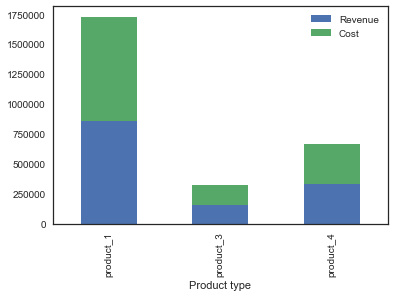

In [184]:
product_performance.set_index('Product type')[['Revenue','Cost']].plot(kind='bar', stacked=True)

## Customer Acquisition

(New customers added in a time period / Total customers in a time period) x 100

In [266]:
customer_acquisition = data.copy(deep=False)
customer_acquisition.dropna(inplace=True)
customer_acquisition['Month'] = customer_acquisition['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))


In [267]:
acquisitions = {month:customer_acquisition[['Month','Customer id']][customer_acquisition['Month'] == month] for month in customer_acquisition['Month'].unique()}


In [268]:
next_month = list(reversed(sorted(customer_acquisition['Month'].unique())[:-1]))
this_month = list(reversed(sorted(customer_acquisition['Month'].unique())[1:]))
for i in range(customer_acquisition['Month'].nunique()-1):
    acquisitions[next_month[i]] = acquisitions[next_month[i]][
    ~acquisitions[next_month[i]]['Customer id'].isin(acquisitions[this_month[i]]['Customer id'])]

In [269]:
for month in customer_acquisition['Month'].unique():
    acquisitions[month] = acquisitions[month].groupby('Month').nunique()

In [271]:
new_acquisitions = pd.concat([acquisitions[row].iloc[:,1:] for row in acquisitions], axis=0)

In [287]:
new_acquisitions.sort_values('Month')

,Customer id
Month,
2015-01,73
2015-02,122
2015-03,161
2015-04,243
2015-05,224
2015-06,460
2015-07,765
2015-08,1243
2015-09,1558


## Repeat Purchase Volume

Number of sales coming from repeat purchases

In [276]:
repeated_customers = data.copy(deep=False)
repeated_customers.dropna(inplace=True)
repeated_customers['Month'] = repeated_customers['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))

In [277]:
repeated = {month: repeated_customers[['Month','Customer id']][repeated_customers['Month'] == month] for month in repeated_customers['Month'].unique()}


In [278]:
next_month = list(reversed(sorted(repeated_customers['Month'].unique())[:-1]))
this_month = list(reversed(sorted(repeated_customers['Month'].unique())[1:]))
for i in range(repeated_customers['Month'].nunique()-1):
    repeated[next_month[i]] = repeated[next_month[i]][
    repeated[next_month[i]]['Customer id'].isin(repeated[this_month[i]]['Customer id'])]

In [279]:
for month in repeated_customers['Month'].unique():
    repeated[month] = repeated[month].groupby('Month').nunique()

In [283]:
repeated_purchases = pd.concat([repeated[row].iloc[:,1:] for row in repeated], axis=0)

In [286]:
repeated_purchases.sort_values('Month')

,Customer id
Month,
2015-01,30
2015-02,46
2015-03,74
2015-04,92
2015-05,110
2015-06,383
2015-07,545
2015-08,648
2015-09,804


## Sales Growth by Market Channel

[(Value of sales acquired in current period for a particular segment - Value of sales acquired in the previous period for the same segment) / Value of the sales acquired in the previous period for the same segment] x 100

In [372]:
channel_growth = data.copy(deep=False)
channel_growth.dropna(inplace=True)
channel_growth['Month'] = channel_growth['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))

In [373]:
channel_growth = channel_growth.groupby(['Month','Marketing channel']).agg({'Revenue': np.sum})

In [378]:
grouped = [channel_growth[channel_growth.index.get_level_values('Marketing channel').isin([group])].groupby(['Month','Marketing channel'])['Revenue'].sum().shift(1) for group in channel_growth.index.levels[1]]

In [379]:
channel_growth = channel_growth.merge(right=pd.DataFrame(pd.concat(grouped)), how='left',left_index=True, right_index=True)


In [381]:
channel_growth['channel_growth'] = (channel_growth['Revenue_x'] - channel_growth['Revenue_y'])/channel_growth['Revenue_y']*100

In [383]:
channel_growth.head()

Revenue_x  Revenue_y  channel_growth
Month   Marketing channel                                      
2015-01 Channel 1            5925.51        NaN             NaN
        Channel 3              55.20        NaN             NaN
        Channel 5              27.82        NaN             NaN
2015-02 Channel 1            8658.92    5925.51       46.129531
        Channel 3             110.40      55.20      100.000000

## Revenue Gained from Top Customers

Revenue from top customer 1 + Revenue from top customer 2 + … + Revenue from top customer 10

In [421]:
top_customers = data.groupby('Customer id')['Revenue'].sum().sort_values(ascending=False).head(10)

In [422]:
top_customers

Customer id
129.0     1371.20
115.0     1365.60
118.0     1354.54
256.0     1343.60
212.0     1326.60
23.0      1326.60
211.0     1306.80
215.0     1293.40
78.0      1286.64
4035.0    1263.63
Name: Revenue, dtype: float64

## Customer Lifetime Value (CLV or LTV)

Lifetime Value = Gross Margin % X ( 1 / Monthly Churn ) X Avg. Monthly Subscription Revenue per Customer

In [500]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import GammaGammaFitter,BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix,plot_probability_alive_matrix

In [494]:
clv = data.copy(deep=False)
clv.dropna(inplace=True)
clv['Month'] = clv['Subscription date'].apply(lambda x: x.strftime('%Y-%m'))

In [495]:
#transform data into right CLV format
clv_summary_data = summary_data_from_transaction_data(transactions=clv, 
                                                      customer_id_col='Customer id', 
                                                      datetime_col='Month', 
                                                      monetary_value_col='Revenue',
                                                      observation_period_end=data['Subscription date'].max().strftime('%Y-%m'))

In [496]:
#remove one time buyers and no revenue customers (perhaps gifted subscriptions)
returning_customers_summary = clv_summary_data[(clv_summary_data['frequency']>0) | (clv_summary_data['monetary_value']>0)]

In [497]:
#check monetary value and frequency independence
returning_customers_summary[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,-0.103761
monetary_value,-0.103761,1.000000


In [484]:
#fitting the data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 4733 subjects, p: 4.09, q: 4.09, v: 38.30>


In [487]:
#estimating conditional expected avg profit
avg_expected_profit = ggf.conditional_expected_average_profit(
        clv_summary_data['frequency'],
        clv_summary_data['monetary_value'])

In [492]:
#expected average profit
print(f'''Expected conditional average profit: {avg_expected_profit.mean()}
Average Profit: {clv_summary_data[clv_summary_data['frequency']>0]['monetary_value'].mean()}''')

Expected conditional average profit: 49.392897855965224
Average Profit: 48.45054847919906


In [498]:
#similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(clv_summary_data['frequency'], clv_summary_data['recency'], clv_summary_data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 6900 subjects, a: 0.00, alpha: 123.21, b: 0.00, r: 2.55>


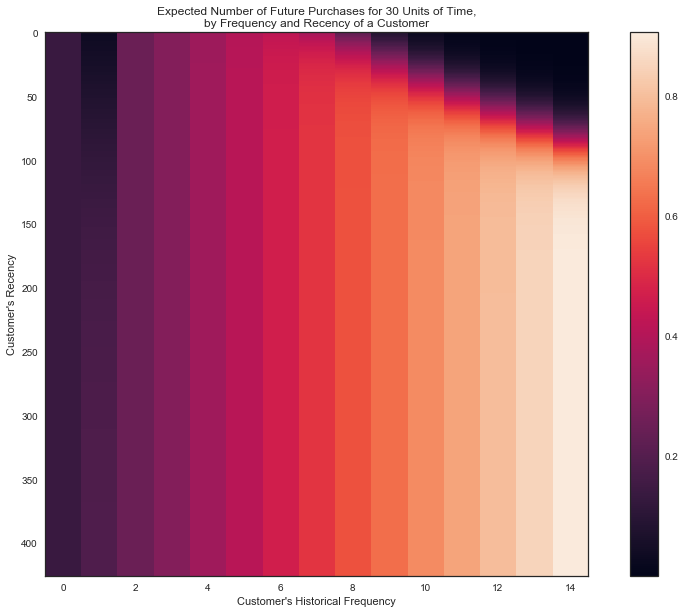

In [505]:
#expected number of future of purchases
plt.figure(figsize=(15,10))
plot_frequency_recency_matrix(bgf, T=30)

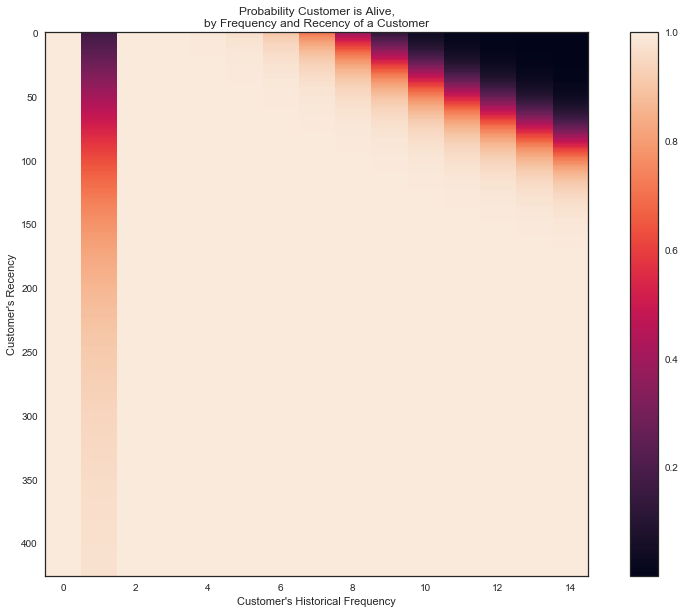

In [507]:
#probability customer is still "alive"
plt.figure(figsize=(15,10))
plot_probability_alive_matrix(bgf)